# QC + Doublet Finder

Basic QC. Find doublets per sample, visualize on overall UMAP and mark them.

In [1]:
library(Seurat)
library(dplyr)
library(ggplot2)
library(patchwork)
library(DoubletFinder)


Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union




In [2]:
DAYS = c("D1M", "D2M")

## Load Data

In [3]:
# aggregated cellranger data
rna.data = Read10X("/srv/scratch/surag/scMultiome-reprog/rna_process/cellranger/aggregate_nonorm/outs/count/filtered_feature_bc_matrix")

In [4]:
rna = CreateSeuratObject(counts = rna.data, project = "scMultiome-reprog", min.cells = 3, min.features = 200)

In [5]:
rna

An object of class Seurat 
31452 features across 16914 samples within 1 assay 
Active assay: RNA (31452 features, 0 variable features)

In [6]:
median(Matrix::colSums(rna@assays$RNA@counts))

[1] 3188.5

In [7]:
rownames(rna)[grep("lnc", rownames(rna), ignore.case = T)]

[1] "LNCTAM34A" "THORLNC"   "LNCSRLR"   "LNCPRESS2" "FILNC1"    "LNCPRESS1"
 [7] "FLNC"      "FLNC-AS1"  "LNCOC1"    "LNCARSR"   "LNCAROD"   "LNCOG"    
[13] "ARLNC1"

In [8]:
head(colnames(rna))

[1] "AAACAGCCAATCCTGA-1" "AAACAGCCAATTAAGG-1" "AAACAGCCAGAGGGAG-1"
[4] "AAACAGCCAGGACCTT-1" "AAACATGCAAATACCT-1" "AAACATGCAATTGAAG-1"

In [9]:
rna[["sample"]] = DAYS[as.numeric(lapply(strsplit(colnames(rna), "-"), "[[", 2))]

In [10]:
head(rna@meta.data)

orig.ident        nCount_RNA nFeature_RNA sample
AAACAGCCAATCCTGA-1 scMultiome-reprog  4971      2446         D1M   
AAACAGCCAATTAAGG-1 scMultiome-reprog  1930      1324         D1M   
AAACAGCCAGAGGGAG-1 scMultiome-reprog  1471      1109         D1M   
AAACAGCCAGGACCTT-1 scMultiome-reprog 39185      8537         D1M   
AAACATGCAAATACCT-1 scMultiome-reprog  8360      3629         D1M   
AAACATGCAATTGAAG-1 scMultiome-reprog  1001       730         D1M

In [11]:
ncol(rna)

[1] 16914

In [12]:
table(rna@meta.data$sample)


  D1M   D2M 
 6716 10198 

## Process

### QC Filters

In [13]:
rna[["percent.mt"]] = PercentageFeatureSet(rna, pattern="^MT-")
rna[["percent.oskm"]] = PercentageFeatureSet(rna, pattern="^(POU5F1|KLF4|MYC|SOX2)$")

In [18]:
quantile(rna@meta.data$nFeature_RNA, c(0, 0.1, 0.25, 0.5, 0.9, .99, 1))

0%      10%      25%      50%      90%      99%     100% 
  351.00   897.00  1343.00  1983.00  4583.70  8960.96 12837.00

In [19]:
quantile(rna@meta.data$nCount_RNA, c(0, 0.1, 0.25, 0.5, 0.9, .99, 1))

0%       10%       25%       50%       90%       99%      100% 
   499.00   1161.00   1904.25   3188.50  10926.50  44058.31 149174.00

In [21]:
quantile(rna@meta.data$percent.mt, c(0, 0.1, 0.25, 0.5, 0.9, .99, 1))

0%        10%        25%        50%        90%        99%       100% 
 0.0000000  0.8537374  1.2407063  1.8175336  3.6610504  6.7685160 17.5900277

In [22]:
quantile(rna@meta.data$percent.oskm, c(0, 0.1, 0.25, 0.5, 0.9, .99, 1))

0%         10%         25%         50%         90%         99% 
 0.00000000  0.00000000  0.01786113  0.05527682  0.54642182  8.70016702 
       100% 
32.89902280

In [24]:
quantile(rna@meta.data$percent.oskm[rna$sample=="D1M"], c(0, 0.1, 0.25, 0.5, 0.9, .95, .99, 1))

0%        10%        25%        50%        90%        95%        99% 
0.00000000 0.00000000 0.00770886 0.04472286 0.26824042 0.45761360 1.50910150 
      100% 
8.11843362

In [25]:
quantile(rna@meta.data$percent.oskm[rna$sample=="D2M"], c(0, 0.1, 0.25, 0.5, 0.9, .95, .99, 1))

0%         10%         25%         50%         90%         95% 
 0.00000000  0.00000000  0.02324502  0.06330116  1.41153331  4.53141671 
        99%        100% 
10.42231245 32.89902280

In [26]:
qc_plot <- function(df, xlab, ylab, xline, yline, base_size=18) {
    ggplot(df, aes(x=x,y=y)) +
    stat_binhex(aes(fill=log10(1+..count..)), bins=100) +
    scale_fill_viridis_c() +
    xlab(xlab) + ylab(ylab) +
    geom_vline(xintercept = xline, col='red') + 
    geom_hline(yintercept = yline, col='red') +
    theme_bw(base_size=base_size)
}

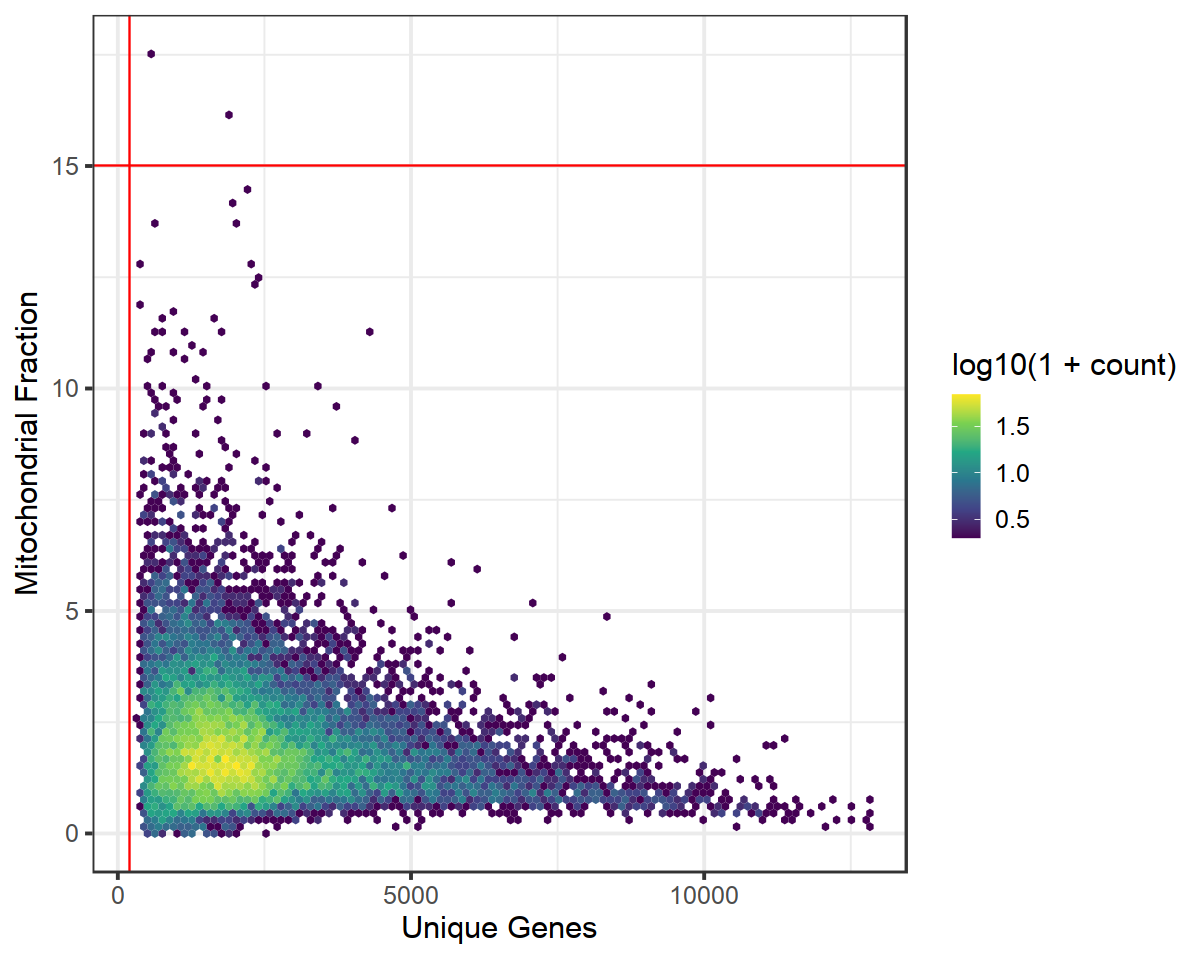

In [27]:
options(repr.plot.width = 10, repr.plot.height = 8)
qc_plot(data.frame(
    x=rna@meta.data$nFeature_RNA,
    y=rna@meta.data$percent.mt), 
        "Unique Genes", 
        "Mitochondrial Fraction",
       200, 15)

In [33]:
mt_vs_log_ct = list()

i=1
for (x in DAYS) {
   mt_vs_log_ct[[i]] = qc_plot(data.frame(
       x=log10(rna$nCount_RNA[rna$sample==x]),
       y=rna$percent.mt[rna$sample==x]), 
       "Log Counts", 
       "Mitochondrial Fraction",
       log10(2000), 15,
                               base_size=24) + 
    ggtitle(x) +
    xlim(c(2.5,5.5)) +
    ylim(c(-1,101)) +
    theme(plot.title = element_text(hjust = 0.5, size=28),
         legend.position = "none")
    
    i = i + 1
}

mt_vs_log_ct[[i]] = cowplot::get_legend(mt_vs_log_ct[[i-1]] + 
                                        theme(legend.position="right", 
                                              legend.key.width = unit(2, "cm"),
                                             legend.key.height = unit(1, "cm")) +
                                       scale_fill_viridis_c(name="Log Density",
                                                            labels=c()))

all_mt_vs_log_ct = wrap_plots(mt_vs_log_ct, nrow = 2)

Scale for 'fill' is already present. Adding another scale for 'fill', which
will replace the existing scale.



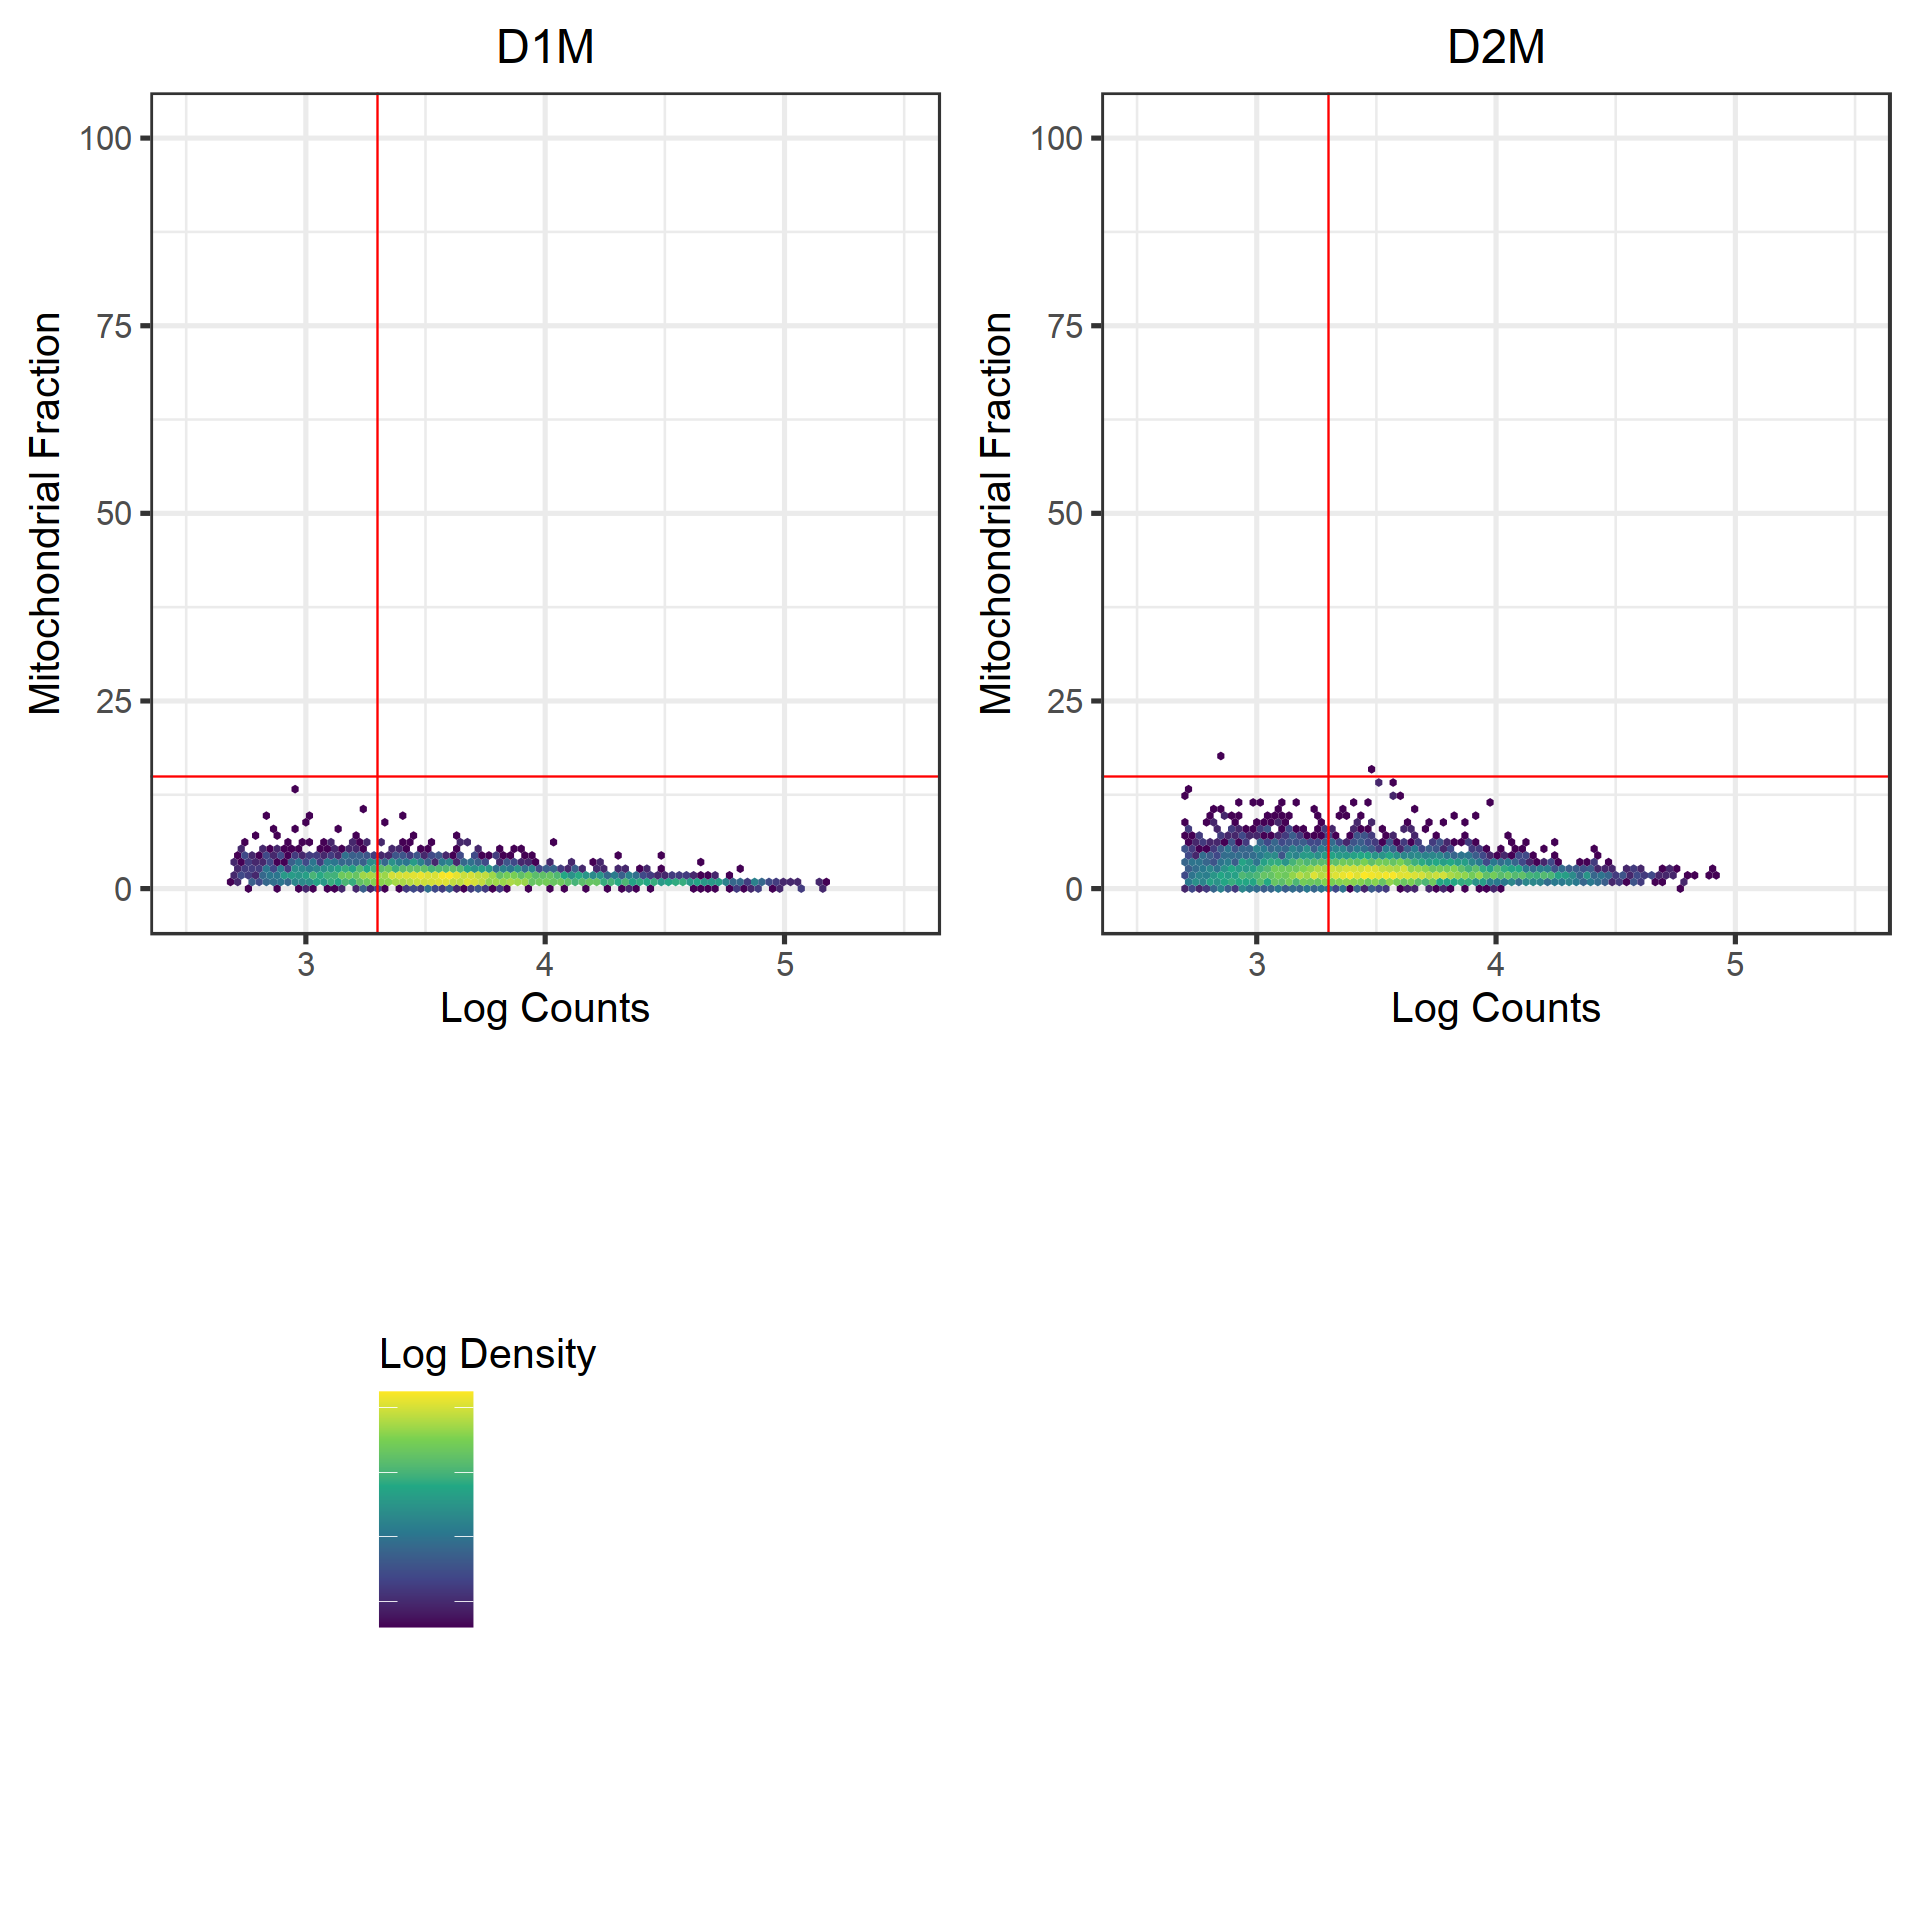

In [38]:
options(repr.plot.width = 16, repr.plot.height = 16)
all_mt_vs_log_ct

In [39]:
ggsave("./QC_plots/20220606_QC.pdf", all_mt_vs_log_ct, height=16, width=16)

In [14]:
rev(sort(table(rna$sample[rna$percent.oskm>50])))
rev(sort(table(rna$sample[rna$percent.oskm>10])))

integer(0)

D2M 
119

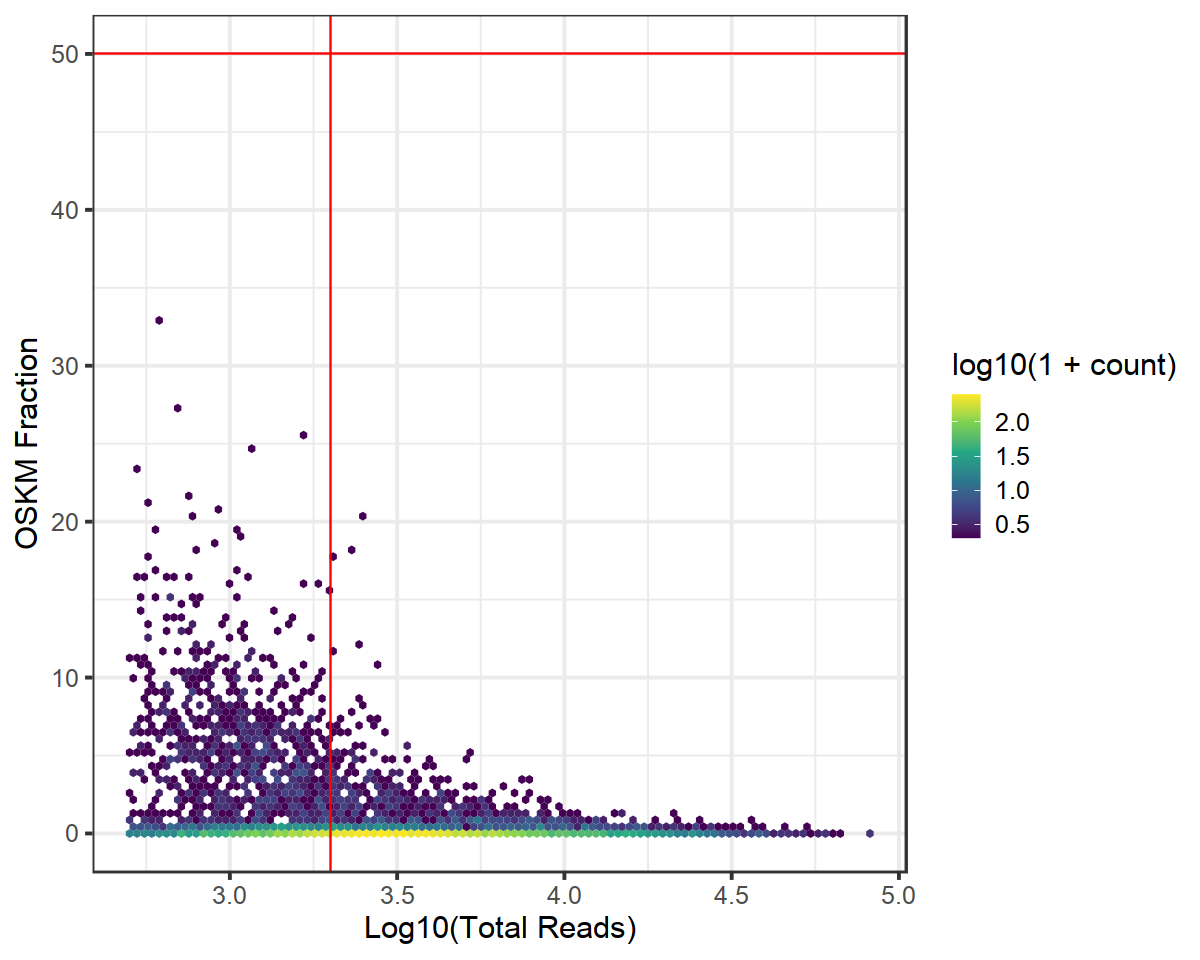

In [42]:
options(repr.plot.width = 10, repr.plot.height = 8)
qc_plot(data.frame(
    x=log10(rna$nCount_RNA[rna$sample=="D2M"]),
    y=rna$percent.oskm[rna$sample=="D2M"]), 
        "Log10(Total Reads)", 
        "OSKM Fraction",
       log10(2000), 50)

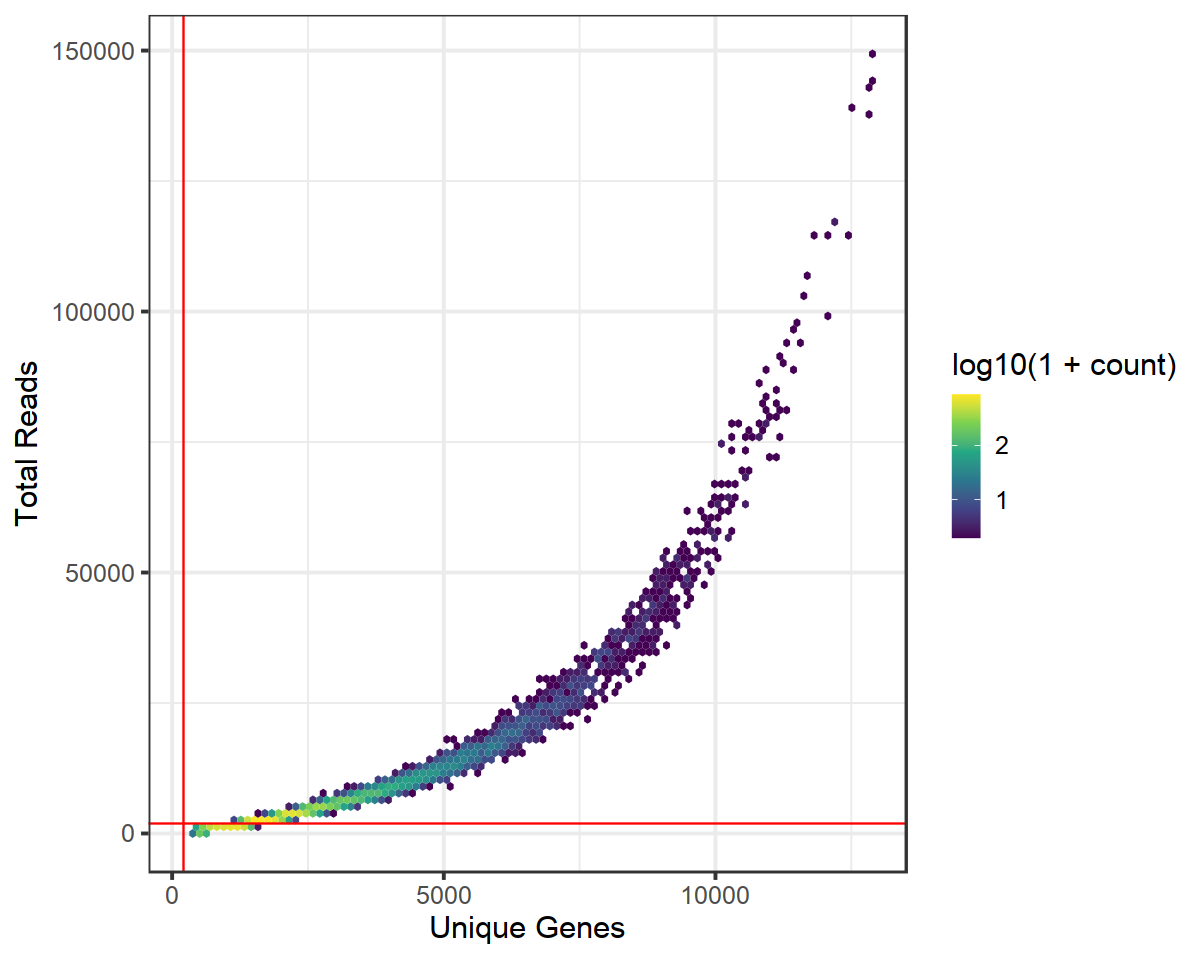

In [43]:
options(repr.plot.width = 10, repr.plot.height = 8)
qc_plot(data.frame(x=rna@meta.data$nFeature_RNA,
                   y=rna@meta.data$nCount_RNA),
        "Unique Genes", "Total Reads",
       200,2000)

In [15]:
head(rna@meta.data)

orig.ident        nCount_RNA nFeature_RNA sample percent.mt
AAACAGCCAATCCTGA-1 scMultiome-reprog  4971      2446         D1M    0.6638503 
AAACAGCCAATTAAGG-1 scMultiome-reprog  1930      1324         D1M    0.8808290 
AAACAGCCAGAGGGAG-1 scMultiome-reprog  1471      1109         D1M    1.7675051 
AAACAGCCAGGACCTT-1 scMultiome-reprog 39185      8537         D1M    0.9595508 
AAACATGCAAATACCT-1 scMultiome-reprog  8360      3629         D1M    1.5191388 
AAACATGCAATTGAAG-1 scMultiome-reprog  1001       730         D1M    2.0979021 
                   percent.oskm
AAACAGCCAATCCTGA-1 0.10058338  
AAACAGCCAATTAAGG-1 0.00000000  
AAACAGCCAGAGGGAG-1 0.00000000  
AAACAGCCAGGACCTT-1 0.09442389  
AAACATGCAAATACCT-1 0.00000000  
AAACATGCAATTGAAG-1 0.69930070

In [16]:
md = rna@meta.data
conds = md$nFeature_RNA > 200 & md$percent.mt <15 & md$nCount_RNA > 2000 & md$nCount_RNA < 1e5 
sum(conds)
table(md$sample[conds])

[1] 12317


 D1M  D2M 
5324 6993 

In [17]:
select_bool = rep(0, ncol(rna))
select_bool[conds] = 1
rna[['selected']]= select_bool

In [18]:
# rna_subset <- subset(rna, subset = nFeature_RNA > 200 & nFeature_RNA < 5000 & percent.mt < 10)
rna_subset = subset(rna, subset = selected==1)

In [19]:
table(rna_subset@meta.data$sample)


 D1M  D2M 
5324 6993 

## DoubletFinder

In [20]:
doublets = c()

# TODO: technically pK needs to be optimised per sample [need to code that in]
for (d in DAYS) {
    rna_sample = subset(rna_subset, subset = sample==d)
    
    rna_sample <- NormalizeData(rna_sample)
    rna_sample <- FindVariableFeatures(rna_sample, selection.method = "vst", nfeatures = 2000)
    all.genes <- rownames(rna_sample)
    rna_sample <- ScaleData(rna_sample, features = all.genes)
    rna_sample <- RunPCA(rna_sample, features = VariableFeatures(object = rna_sample))
    rna_sample <- RunUMAP(rna_sample, dims = 1:10)
    
    nExp_poi <- round(0.15*ncol(rna_sample)) # 15% stringent (?)
    rna_sample <- doubletFinder_v3(rna_sample, PCs = 1:10, pN = 0.25, pK = 0.01, nExp = nExp_poi, reuse.pANN = FALSE, sct = FALSE)
    
    doublets = c(doublets, rownames(rna_sample@meta.data)[rna_sample@meta.data[, grep("DF.classifications", colnames(rna_sample@meta.data))[1]]=="Doublet"])
}

Centering and scaling data matrix

PC_ 1 
Positive:  POU5F1, SOX2, KLF4, LHFPL3, COL21A1, BBS9, KCNMB2-AS1, AL008633.1, LINC02615, PDE1A 
	   BMPR1B, LINC01933, RNF217-AS1, C5AR1, CASC15, MAP2, TMTC2, JAG1, DNAH12, AL136456.1 
	   ANK2, EDIL3, ASB15, CRB1, AC024901.1, CRPPA, ANKS1B, THRB, RALGPS1, DLG2 
Negative:  THBS1, FMN2, FST, HMGA2-AS1, NEAT1, LGALS1, MIR31HG, LDB2, ITGBL1, SERPINB2 
	   MT2A, PRR16, SEMA3C, HAS2, CHRM2, ADAMTS6, CFAP299, RFX8, KIF18A, DCC 
	   HERC4, GREM2, S100A6, SNHG29, LRRC75A, APOLD1, AC004917.1, TRIM55, PDE5A, DPF3 
PC_ 2 
Positive:  LHFPL3, LINC02615, AC024901.1, DNAH12, COL21A1, CCDC190, AL136456.1, WDR49, CYP2C19, LHFPL3-AS1 
	   LINC01933, DDR2, LRRC23, FMN1, KCNB1, LHFPL3-AS2, SLC9B1, BMPR1B, AL008633.1, AC009264.1 
	   CYP2C18, SLC10A1, AC018754.1, ASB15, UNC5C, LINC02694, AC079760.2, SOX2-OT, LINC01208, LGR5 
Negative:  MAP2, HS3ST5, CACNA2D1, HDAC2-AS2, THSD7A, KCNQ5, KLF3, NFATC2, AC099520.1, CBLB 
	   DOK6, FERMT1, EDIL3, LINC02511, ZNF804A, COL3

[1] "Creating 1775 artificial doublets..."
[1] "Creating Seurat object..."
[1] "Normalizing Seurat object..."
[1] "Finding variable genes..."
[1] "Scaling data..."


Centering and scaling data matrix



[1] "Running PCA..."
[1] "Calculating PC distance matrix..."
[1] "Computing pANN..."
[1] "Classifying doublets.."


Centering and scaling data matrix

PC_ 1 
Positive:  LHFPL3, SOX2, KLF4, POU5F1, AC116634.1, SOX2-OT, AC138627.1, PLPPR1, CXCL13, DLG2 
	   OR9Q1, KCNB1, PEBP4, KCNMB2, KCNMB2-AS1, PKN2-AS1, SGO1-AS1, CCDC26, AL136456.1, LINC02636 
	   PTGER3, MTUS2, CHODL, AC009522.1, ANXA10, LINC02694, AC114316.1, RGS6, AC061958.1, LHFPL3-AS1 
Negative:  VEGFC, COL1A1, UACA, LGALS1, CALR, FAM155A, FN1, PRR16, SLC7A11, MIR31HG 
	   INHBA, THBS1, HAS2, S100A6, MT2A, TMSB10, ITGA2, TOP2A, MYBL1, EIF5A 
	   NEAT1, LDB2, FMN2, SFRP1, MT-CO2, SLC8A1, CCN1, ASPM, LRRC75A, DCLK2 
PC_ 2 
Positive:  COL1A1, UACA, FN1, FMN1, INHBA, LGALS1, ITGA2, THBS1, NTM, ADAMTS6 
	   AFF3, RFX8, CHRM2, FMN2, AC009264.1, VEGFC, MT2A, PRR16, DCC, SFRP1 
	   CFAP299, TMSB10, ARHGAP24, MMP1, TNC, MIR31HG, PDE5A, SERPINB2, SLC4A4, SGIP1 
Negative:  HS3ST5, MAP2, AC099520.1, HDAC2-AS2, JAKMIP2, DOK6, EDIL3, AC092957.1, THSD7A, PARD3B 
	   COL11A1, KCNQ5, LYPLAL1-DT, MAP4K3, ATP9B, EFNA5, CYP1B1, NKAIN2, ST8SIA4, PCDH15 
	   COBLL

[1] "Creating 2331 artificial doublets..."
[1] "Creating Seurat object..."
[1] "Normalizing Seurat object..."
[1] "Finding variable genes..."
[1] "Scaling data..."


Centering and scaling data matrix



[1] "Running PCA..."
[1] "Calculating PC distance matrix..."
[1] "Computing pANN..."
[1] "Classifying doublets.."


In [21]:
length(unique(doublets))

[1] 1848

In [22]:
head(doublets)

[1] "AAACAGCCAGGACCTT-1" "AAACATGCAAATACCT-1" "AAACATGCACTAAGCC-1"
[4] "AAACCGAAGGTAACGA-1" "AAACGGATCCTTCGTA-1" "AAACGTACAGCTCATA-1"

## Viz

## With doublets

In [23]:
rna_w_doub = rna_subset
    
rna_w_doub <- NormalizeData(rna_w_doub)
rna_w_doub <- FindVariableFeatures(rna_w_doub, selection.method = "vst", nfeatures = 2000)
all.genes <- rownames(rna_w_doub)
rna_w_doub <- ScaleData(rna_w_doub, features = all.genes)
rna_w_doub <- RunPCA(rna_w_doub, features = VariableFeatures(object = rna_w_doub))
rna_w_doub <- RunUMAP(rna_w_doub, dims = 1:10)

Centering and scaling data matrix

PC_ 1 
Positive:  SOX2, LHFPL3, POU5F1, KLF4, SOX2-OT, AC116634.1, AC138627.1, DLG2, KCNMB2-AS1, AL136456.1 
	   KCNB1, KCNMB2, PLPPR1, PEBP4, LINC01208, CXCL13, LINC02694, PKN2-AS1, ANKS1B, SGO1-AS1 
	   COL21A1, OR9Q1, MTUS2, LHFPL3-AS1, CASC15, ANXA10, DNAH12, AL008633.1, AC024901.1, BBS9 
Negative:  VEGFC, SMURF2, CRIM1, MIR222HG, HMGA2-AS1, CDH13, THBS1, PRR16, MIR31HG, FMN2 
	   MYBL1, NAV3, HAS2, MT2A, SLC8A1, S100A6, CALR, ITGBL1, RFX8, INSYN2B 
	   FST, DCLK2, SEMA3C, NEAT1, ADAMTS6, SERPINB2, ALCAM, EIF5A, KCNMA1, BIRC2 
PC_ 2 
Positive:  MAP2, HS3ST5, HDAC2-AS2, AC099520.1, EDIL3, DOK6, JAKMIP2, CACNA2D1, THSD7A, AC092957.1 
	   KCNQ5, COL11A1, EFNA5, KLF3, FERMT1, VAV2, NFATC2, COBLL1, FBN2, PLAGL1 
	   THRB, COL3A1, ST8SIA4, SYNE1, AC073050.1, CYP1B1, CERS6, LUZP2, CD55, AC119868.2 
Negative:  SMURF2, FMN1, LHFPL3, AC116634.1, THBS1, AC009264.1, SOX2-OT, ADAMTS6, KCNB1, VEGFC 
	   CHRM2, OR9Q1, AC138627.1, FMN2, PLPPR1, PEBP4, RFX8, CRIM1

In [24]:
rna_w_doub

An object of class Seurat 
31452 features across 12317 samples within 1 assay 
Active assay: RNA (31452 features, 2000 variable features)
 2 dimensional reductions calculated: pca, umap

In [25]:
rna_w_doub[['doublet']] = rownames(rna_w_doub@meta.data) %in% doublets

In [26]:
plot_df <- data.frame(pc1=data.frame(Embeddings(rna_w_doub, reduction='umap'))$UMAP_1,
                 pc2=data.frame(Embeddings(rna_w_doub, reduction='umap'))$UMAP_2,
                 sample=rna_w_doub@meta.data$sample)
plot_df = plot_df[sample(dim(plot_df)[1]), ]

by_day <- ggplot(plot_df) +
geom_point(aes(x=pc1, y=pc2, color=factor(sample, levels=DAYS)), stroke=0, size=1) +
theme_classic() +
xlab("UMAP 1") + ylab("UMAP 2") +
theme(plot.title = element_text(hjust = 0.5),
      text = element_text(size=12),
      axis.line=element_blank(),
      axis.text.x=element_blank(),
      axis.text.y=element_blank(),
      axis.ticks=element_blank(),
      panel.border = element_rect(colour = "black", fill=NA, size=0.5)) +
guides(colour = guide_legend(title="Day",
     override.aes = list(shape=16, alpha=1, size=4)))

In [27]:
plot_df <- data.frame(pc1=data.frame(Embeddings(rna_w_doub, reduction='umap'))$UMAP_1,
                 pc2=data.frame(Embeddings(rna_w_doub, reduction='umap'))$UMAP_2,
                 doub=rna_w_doub@meta.data$doublet)
plot_df = plot_df[sample(dim(plot_df)[1]), ]

by_doub <- ggplot(plot_df) +
geom_point(aes(x=pc1, y=pc2, color=doub), stroke=0, size=1) +
theme_classic() +
xlab("UMAP 1") + ylab("UMAP 2") +
theme(plot.title = element_text(hjust = 0.5),
      text = element_text(size=12),
      axis.line=element_blank(),
      axis.text.x=element_blank(),
      axis.text.y=element_blank(),
      axis.ticks=element_blank(),
      panel.border = element_rect(colour = "black", fill=NA, size=0.5)) +
guides(colour = guide_legend(title="Day",
     override.aes = list(shape=16, alpha=1, size=4)))

In [28]:
plot_df <- data.frame(pc1=data.frame(Embeddings(rna_w_doub, reduction='umap'))$UMAP_1,
                 pc2=data.frame(Embeddings(rna_w_doub, reduction='umap'))$UMAP_2,
                 mt=rna_w_doub@meta.data$percent.mt)
plot_df = plot_df[sample(dim(plot_df)[1]), ]

by_mt <- ggplot(plot_df, aes(x=pc1, y=pc2, col=as.numeric(mt))) +
geom_point(stroke=0, size=1) +
theme_classic() +
scale_color_viridis_c() +
xlab("UMAP 1") + ylab("UMAP 2") +
theme(plot.title = element_text(hjust = 0.5),
      text = element_text(size=12),
      axis.line=element_blank(),
      axis.text.x=element_blank(),
      axis.text.y=element_blank(),
      axis.ticks=element_blank(),
      panel.border = element_rect(colour = "black", fill=NA, size=0.5)) 

In [29]:
library(scales)

In [30]:
plot_df <- data.frame(pc1=data.frame(Embeddings(rna_w_doub, reduction='umap'))$UMAP_1,
                 pc2=data.frame(Embeddings(rna_w_doub, reduction='umap'))$UMAP_2,
                 oskm=rna_w_doub$percent.oskm)
plot_df = plot_df[sample(dim(plot_df)[1]), ]

by_oskm <- ggplot(plot_df, aes(x=pc1, y=pc2, col=as.numeric(oskm))) +
geom_point(stroke=0, size=1) +
theme_classic() +
scale_color_viridis_c(limits=c(0,quantile(rna_w_doub$percent.oskm, .99)), oob=squish) +
xlab("UMAP 1") + ylab("UMAP 2") +
theme(plot.title = element_text(hjust = 0.5),
      text = element_text(size=12),
      axis.line=element_blank(),
      axis.text.x=element_blank(),
      axis.text.y=element_blank(),
      axis.ticks=element_blank(),
      panel.border = element_rect(colour = "black", fill=NA, size=0.5)) 

In [31]:
plot_df <- data.frame(pc1=data.frame(Embeddings(rna_w_doub, reduction='umap'))$UMAP_1,
                 pc2=data.frame(Embeddings(rna_w_doub, reduction='umap'))$UMAP_2,
                 reads=log10(rna_w_doub$nCount_RNA))
plot_df = plot_df[sample(dim(plot_df)[1]), ]

by_reads <- ggplot(plot_df, aes(x=pc1, y=pc2, col=as.numeric(reads))) +
geom_point(stroke=0, size=1) +
theme_classic() +
scale_color_viridis_c() +
xlab("UMAP 1") + ylab("UMAP 2") +
theme(plot.title = element_text(hjust = 0.5),
      text = element_text(size=12),
      axis.line=element_blank(),
      axis.text.x=element_blank(),
      axis.text.y=element_blank(),
      axis.ticks=element_blank(),
      panel.border = element_rect(colour = "black", fill=NA, size=0.5)) 

In [32]:
plot_df <- data.frame(pc1=data.frame(Embeddings(rna_w_doub, reduction='umap'))$UMAP_1,
                 pc2=data.frame(Embeddings(rna_w_doub, reduction='umap'))$UMAP_2,
                 reads=log10(rna_w_doub$nFeature_RNA))
plot_df = plot_df[sample(dim(plot_df)[1]), ]

by_nFeat <- ggplot(plot_df, aes(x=pc1, y=pc2, col=as.numeric(reads))) +
geom_point(stroke=0, size=1) +
theme_classic() +
scale_color_viridis_c() +
xlab("UMAP 1") + ylab("UMAP 2") +
theme(plot.title = element_text(hjust = 0.5),
      text = element_text(size=12),
      axis.line=element_blank(),
      axis.text.x=element_blank(),
      axis.text.y=element_blank(),
      axis.ticks=element_blank(),
      panel.border = element_rect(colour = "black", fill=NA, size=0.5)) 

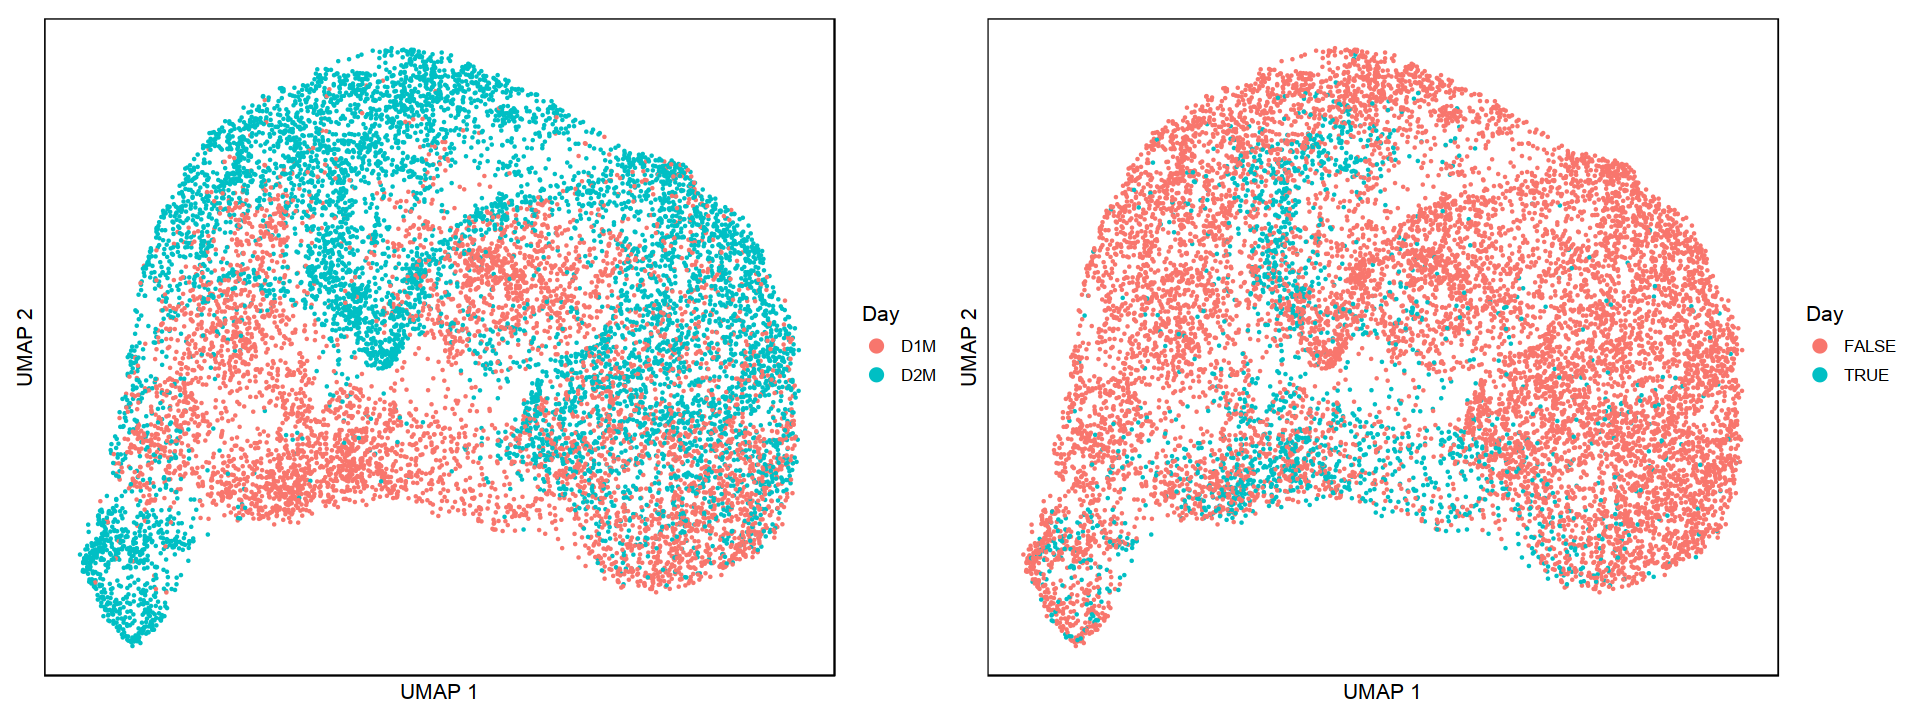

In [33]:
options(repr.plot.width = 16, repr.plot.height = 6)

by_day | by_doub

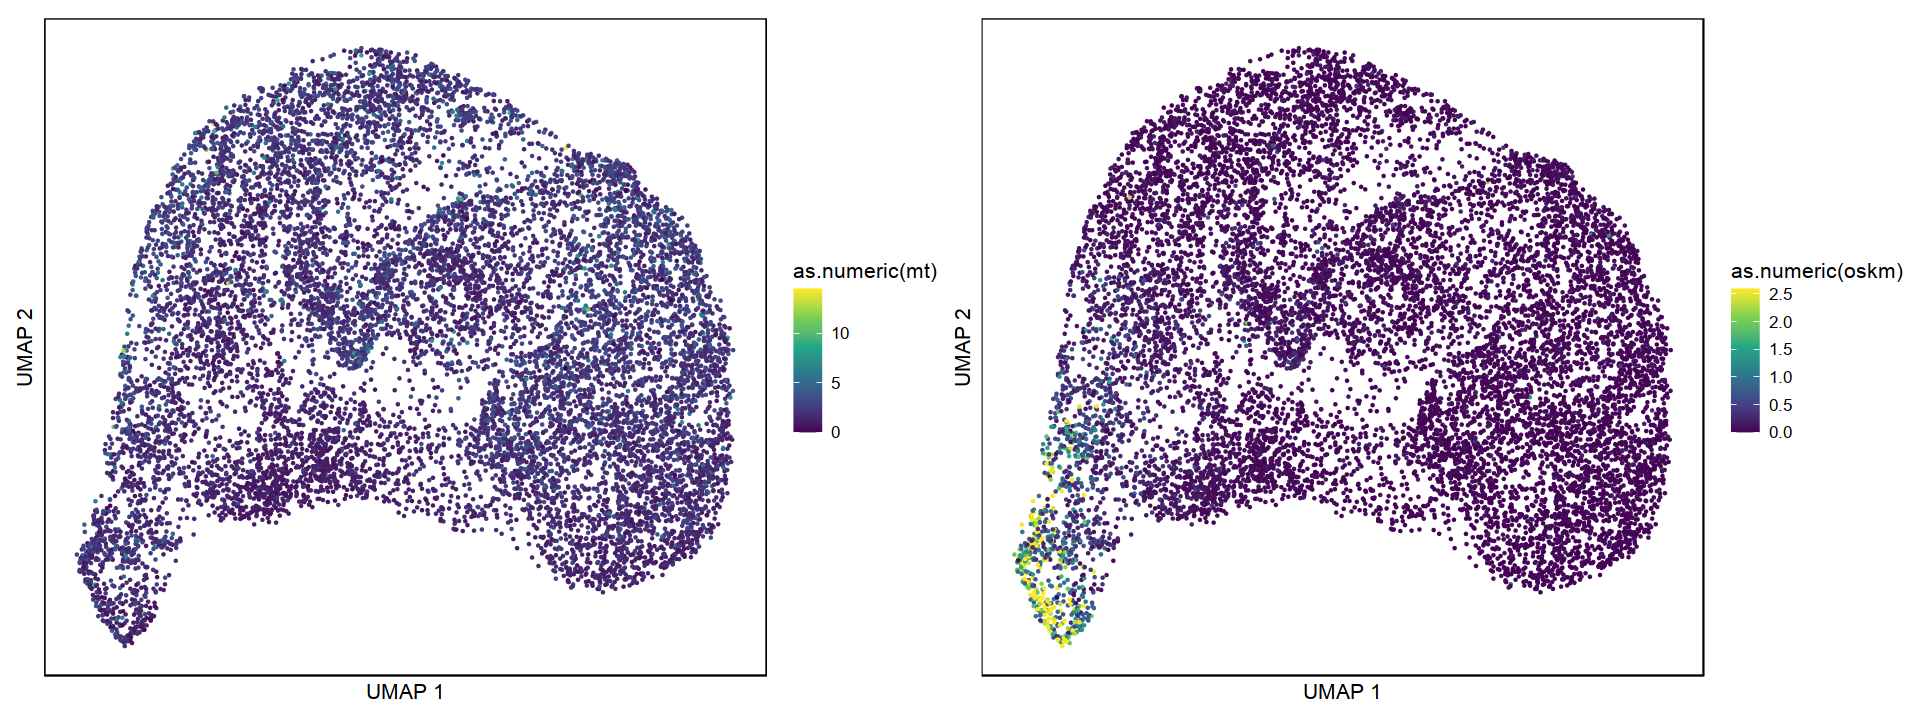

In [34]:
options(repr.plot.width = 16, repr.plot.height = 6)

by_mt | by_oskm

Seems to be that cells with high OSK expression clump together. Would not expect much OSKM expression since this is single nucleus data. So going to exclude those.

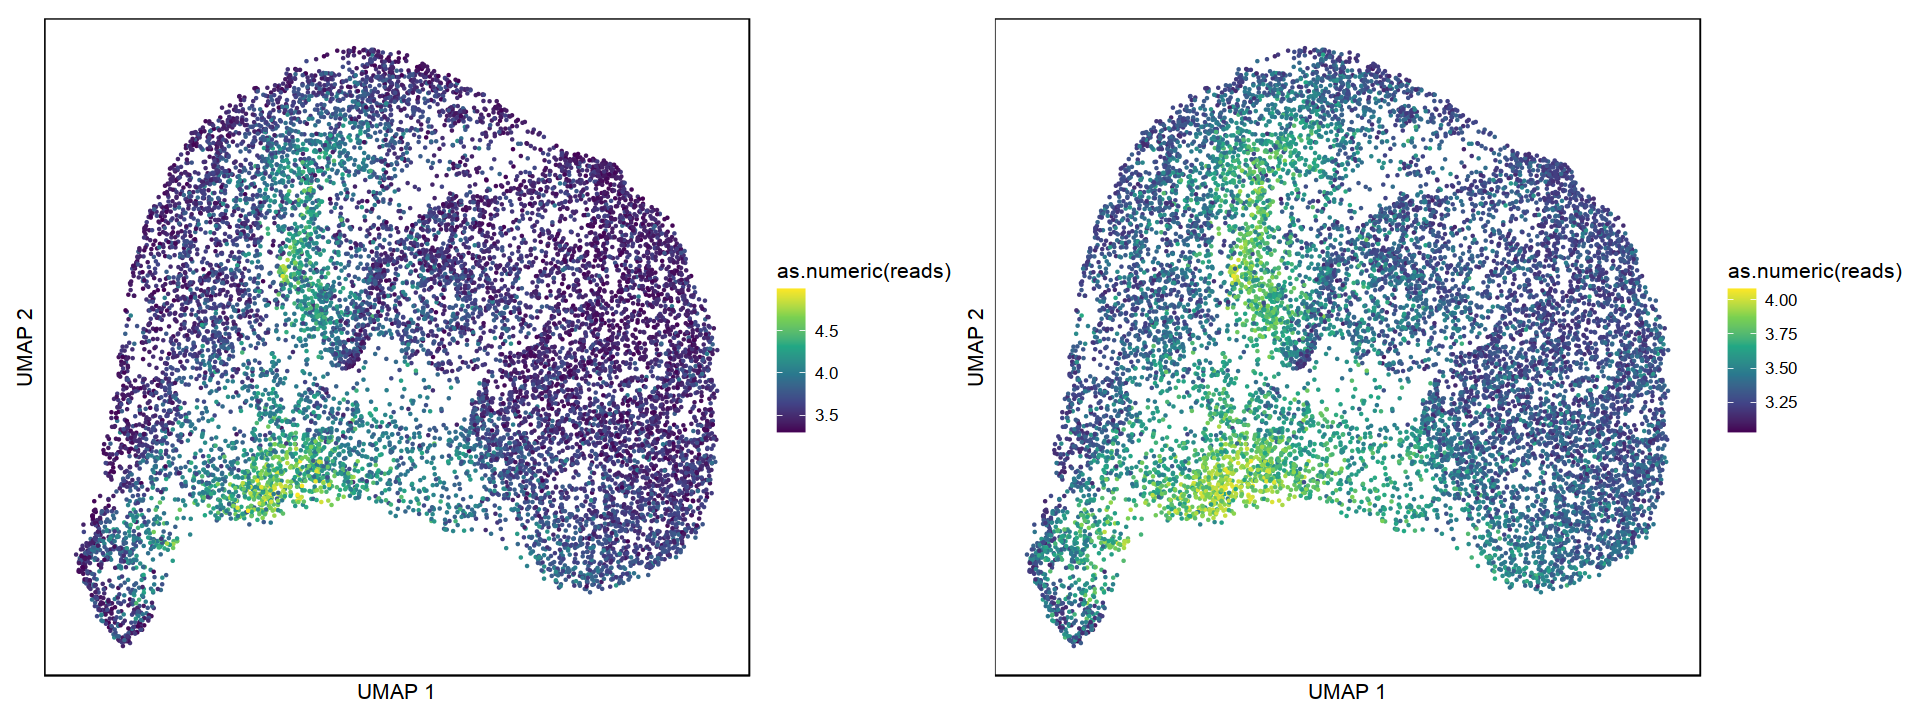

In [35]:
options(repr.plot.width = 16, repr.plot.height = 6)

by_reads | by_nFeat

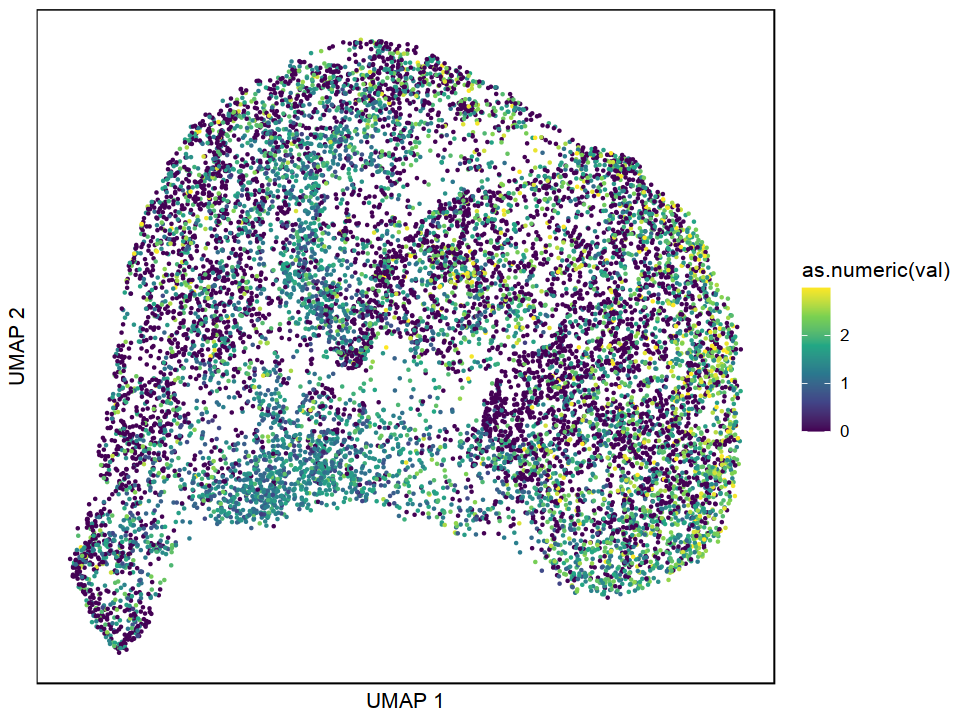

In [40]:
options(repr.plot.width = 8, repr.plot.height = 6)

val = as.vector(rna_w_doub[['RNA']]["TOP2A"])
plot_df <- data.frame(pc1=data.frame(Embeddings(rna_w_doub, reduction='umap'))$UMAP_1,
                 pc2=data.frame(Embeddings(rna_w_doub, reduction='umap'))$UMAP_2,
                 val=val)
plot_df = plot_df[sample(dim(plot_df)[1]), ]

ggplot(plot_df, aes(x=pc1, y=pc2, col=as.numeric(val))) +
geom_point(stroke=0, size=1) +
theme_classic() +
scale_color_viridis_c(limits=c(0,quantile(val, .99)), oob=squish) +
xlab("UMAP 1") + ylab("UMAP 2") +
theme(plot.title = element_text(hjust = 0.5),
      text = element_text(size=12),
      axis.line=element_blank(),
      axis.text.x=element_blank(),
      axis.text.y=element_blank(),
      axis.ticks=element_blank(),
      panel.border = element_rect(colour = "black", fill=NA, size=0.5)) 

### ATAC QC comparison

Compare with which cells made it to ATAC and whether ATAC doublets overlap RNA doublets.

In [37]:
atac_to_rna_bc_map = read.table("/srv/scratch/surag/scMultiome-reprog/ATAC.RNA.bc.map.tsv", sep='\t', 
                                header=F, stringsAsFactors=F)
colnames(atac_to_rna_bc_map) = c("ATAC", "RNA")
rownames(atac_to_rna_bc_map) = paste("AAAAAAAA", atac_to_rna_bc_map$ATAC, sep='')
head(atac_to_rna_bc_map)

ATAC             RNA             
AAAAAAAAGTAACACACCCGCTGT GTAACACACCCGCTGT AAACAGCCAAACAACA
AAAAAAAAAAGAACAACCCGCTGT AAGAACAACCCGCTGT AAACAGCCAAACATAG
AAAAAAAAGCCTGTTACCCGCTGT GCCTGTTACCCGCTGT AAACAGCCAAACCCTA
AAAAAAAATTCGCGCACCCGCTGT TTCGCGCACCCGCTGT AAACAGCCAAACCTAT
AAAAAAAAATGGAGGACCCGCTGT ATGGAGGACCCGCTGT AAACAGCCAAACCTTG
AAAAAAAAAACCATGACCCGCTGT AACCATGACCCGCTGT AAACAGCCAAACGCGA

In [38]:
D1M_ATAC_bc = as.character(unlist(read.table("../20220603_Multiome_ArchR/barcodes/20220607_TSS6_nFrag1000_AMULET/D1M.txt")$V1))
D2M_ATAC_bc = as.character(unlist(read.table("../20220603_Multiome_ArchR/barcodes/20220607_TSS6_nFrag1000_AMULET/D2M.txt")$V1))
length(D1M_ATAC_bc)
length(D2M_ATAC_bc)

[1] 4759

[1] 6824

In [39]:
D1M_AMULET_doub = as.character(unlist(read.table("../20220603_Multiome_AMULET/outs/20220607_w_knee_point/D1M_doublet.txt")$V1))
D2M_AMULET_doub = as.character(unlist(read.table("../20220603_Multiome_AMULET/outs/20220607_w_knee_point/D2M_doublet.txt")$V1))
length(D1M_AMULET_doub)
length(D2M_AMULET_doub)

[1] 859

[1] 972

In [41]:
length(intersect(paste(atac_to_rna_bc_map[D1M_AMULET_doub, "RNA"], '1', sep='-'), doublets))
length(intersect(paste(atac_to_rna_bc_map[D2M_AMULET_doub, "RNA"], '2', sep='-'), doublets))

[1] 260

[1] 389

See which cells pass QC in ATAC and which are doublets in above UMAP 

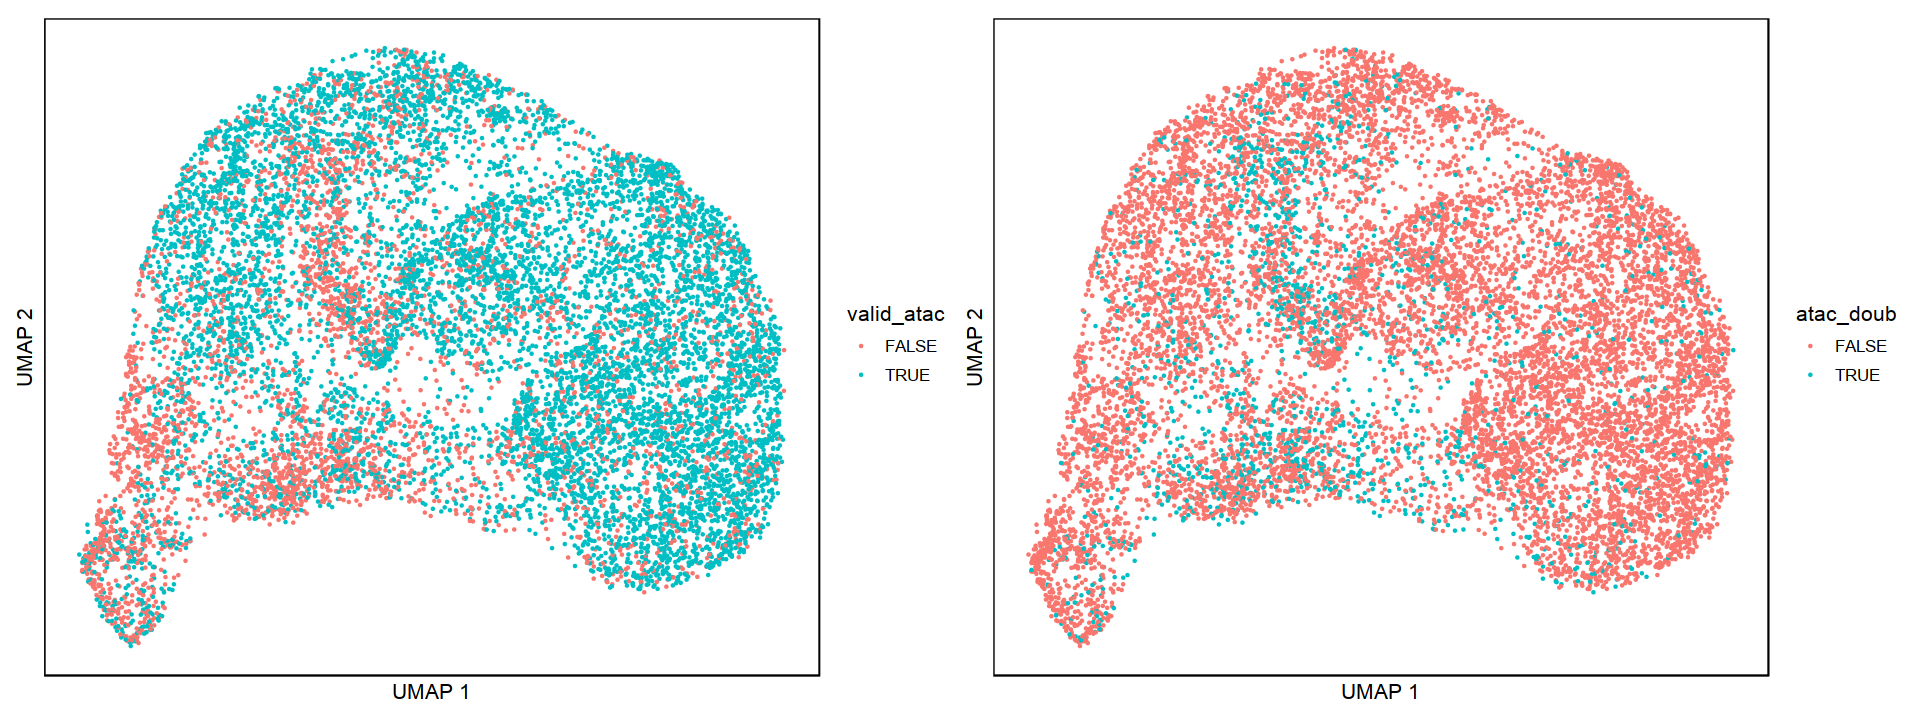

In [42]:
options(repr.plot.width = 16, repr.plot.height = 6)

plot_df <- data.frame(pc1=data.frame(Embeddings(rna_w_doub, reduction='umap'))$UMAP_1,
                 pc2=data.frame(Embeddings(rna_w_doub, reduction='umap'))$UMAP_2,
                 bc=colnames(rna_w_doub))
plot_df$valid_atac = plot_df$bc %in% c(paste(atac_to_rna_bc_map[D1M_ATAC_bc, "RNA"], "1", sep='-'), 
                                       paste(atac_to_rna_bc_map[D2M_ATAC_bc, "RNA"], "2", sep='-'))

plot_df$atac_doub = plot_df$bc %in% c(paste(atac_to_rna_bc_map[D1M_AMULET_doub, "RNA"], "1", sep='-'), 
                                       paste(atac_to_rna_bc_map[D2M_AMULET_doub, "RNA"], "2", sep='-'))
plot_df = plot_df[sample(dim(plot_df)[1]), ]

p1 <- ggplot(plot_df, aes(x=pc1, y=pc2, col=valid_atac)) +
geom_point(stroke=0, size=1) +
theme_classic() +
xlab("UMAP 1") + ylab("UMAP 2") +
theme(plot.title = element_text(hjust = 0.5),
      text = element_text(size=12),
      axis.line=element_blank(),
      axis.text.x=element_blank(),
      axis.text.y=element_blank(),
      axis.ticks=element_blank(),
      panel.border = element_rect(colour = "black", fill=NA, size=0.5))

p2 <- ggplot(plot_df, aes(x=pc1, y=pc2, col=atac_doub)) +
geom_point(stroke=0, size=1) +
theme_classic() +
xlab("UMAP 1") + ylab("UMAP 2") +
theme(plot.title = element_text(hjust = 0.5),
      text = element_text(size=12),
      axis.line=element_blank(),
      axis.text.x=element_blank(),
      axis.text.y=element_blank(),
      axis.ticks=element_blank(),
      panel.border = element_rect(colour = "black", fill=NA, size=0.5))

p1 | p2

Looks like bottom left population which also has relatively high OSKM levels may be technical artefact and most are lost in ATAC.

Remove doublets, OSKM>0.5%, restrict to ATAC QC pass cells.

In [49]:
D1M_final_barcodes = colnames(rna_w_doub)[(rna_w_doub$sample=="D1M") & (rna_w_doub$percent.oskm < 0.5) & (rna_w_doub$doublet == 0) & (colnames(rna_w_doub) %in% paste(atac_to_rna_bc_map[D1M_ATAC_bc, "RNA"], '1', sep='-'))]
D2M_final_barcodes = colnames(rna_w_doub)[(rna_w_doub$sample=="D2M") & (rna_w_doub$percent.oskm < 0.5) & (rna_w_doub$doublet == 0) & (colnames(rna_w_doub) %in% paste(atac_to_rna_bc_map[D2M_ATAC_bc, "RNA"], '2', sep='-'))]

In [50]:
length(D1M_final_barcodes)
length(D2M_final_barcodes)

[1] 3217

[1] 4161

In [54]:
rna_to_atac_bc_map = atac_to_rna_bc_map
rownames(rna_to_atac_bc_map) = rna_to_atac_bc_map$RNA

In [67]:
head(rna_to_atac_bc_map)

ATAC             RNA             
AAACAGCCAAACAACA GTAACACACCCGCTGT AAACAGCCAAACAACA
AAACAGCCAAACATAG AAGAACAACCCGCTGT AAACAGCCAAACATAG
AAACAGCCAAACCCTA GCCTGTTACCCGCTGT AAACAGCCAAACCCTA
AAACAGCCAAACCTAT TTCGCGCACCCGCTGT AAACAGCCAAACCTAT
AAACAGCCAAACCTTG ATGGAGGACCCGCTGT AAACAGCCAAACCTTG
AAACAGCCAAACGCGA AACCATGACCCGCTGT AAACAGCCAAACGCGA

In [57]:
all(lapply(strsplit(D1M_final_barcodes, "-"), "[[", 1) %in% rownames(rna_to_atac_bc_map))
all(lapply(strsplit(D2M_final_barcodes, "-"), "[[", 1) %in% rownames(rna_to_atac_bc_map))

[1] TRUE

[1] TRUE

In [73]:
D1M_final_table = data.frame(ATAC=paste("AAAAAAAA", # constant 8 length string before every ATAC barcode
                                        rna_to_atac_bc_map[unlist(lapply(strsplit(D1M_final_barcodes, "-"), "[[", 1)), "ATAC"],
                                        sep=''),
                            RNA=unlist(lapply(strsplit(D1M_final_barcodes, "-"), "[[", 1)))
D2M_final_table = data.frame(ATAC=paste("AAAAAAAA",
                                        rna_to_atac_bc_map[unlist(lapply(strsplit(D2M_final_barcodes, "-"), "[[", 1)), "ATAC"],
                                        sep=''),
                            RNA=unlist(lapply(strsplit(D2M_final_barcodes, "-"), "[[", 1)))

In [74]:
write.table(D1M_final_table,
            file='./barcodes/20220607_nFeat200_mt15_oskm0.5_nCount2000_doub15_pk0.01_atac_filt/D1M.tsv',
            quote=F,
            row.names=F,
            col.names=T,
           sep='\t')

write.table(D2M_final_table,
            file='./barcodes/20220607_nFeat200_mt15_oskm0.5_nCount2000_doub15_pk0.01_atac_filt/D2M.tsv',
            quote=F,
            row.names=F,
            col.names=T,
           sep='\t')

---

In [70]:
sessionInfo()

R version 3.6.3 (2020-02-29)
Platform: x86_64-conda_cos6-linux-gnu (64-bit)
Running under: Ubuntu 18.04.6 LTS

Matrix products: default
BLAS/LAPACK: /users/surag/anaconda3/envs/r36_cran/lib/libopenblasp-r0.3.9.so

locale:
 [1] LC_CTYPE=en_US.UTF-8       LC_NUMERIC=C              
 [3] LC_TIME=en_US.UTF-8        LC_COLLATE=en_US.UTF-8    
 [5] LC_MONETARY=en_US.UTF-8    LC_MESSAGES=en_US.UTF-8   
 [7] LC_PAPER=en_US.UTF-8       LC_NAME=C                 
 [9] LC_ADDRESS=C               LC_TELEPHONE=C            
[11] LC_MEASUREMENT=en_US.UTF-8 LC_IDENTIFICATION=C       

attached base packages:
[1] grid      stats     graphics  grDevices utils     datasets  methods  
[8] base     

other attached packages:
 [1] scales_1.1.0        KernSmooth_2.23-16  fields_10.3        
 [4] maps_3.3.0          spam_2.5-1          dotCall64_1.0-0    
 [7] DoubletFinder_2.0.3 patchwork_1.0.0     ggplot2_3.3.3      
[10] dplyr_1.0.2         Seurat_3.1.5       

loaded via a namespace (and not attached):
 